# RNN

Ноутбук для прогнозирования статистических показателей игроков NHL на будующий сезон (81 игра).  
Тестируется 2 модели: однонаправленная с одним LSTM слоем и  двумя слоями, из которых 1 двунаправленный

In [31]:
import os
import datetime
import random

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn.metrics as skm
import os

import tensorflow.python.keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
INPUT_DIR = r"F:/YandexDisk/Skill_Factory/NHL_Project/input/nhl-data/csv/"
#INPUT_DIR = r"C:/Users/v.ivanov/YandexDisk/Skill_Factory/NHL_Project/input/nhl-data/csv/"
#INPUT_DIR = r"D:/YandexDisk/Skill_Factory/NHL_Project/input/nhl-data/csv/"

In [4]:
pst = pd.read_csv('pst2.csv')

games = pd.read_csv('games_full.csv')
games['dateTime'] = games['dateTime'].apply(lambda x: x[:10])
games['season'] = games['pk'].apply(lambda x: str(x)[:4]).astype('int')
pst = pst.loc[~pst.player.isna()]

pst = pst.merge(games, left_on='game_id', right_on='pk', how='left')
pst['dateTime'] = pd.to_datetime(pst.dateTime, format='%Y-%m-%d')

pst.drop('season_y', axis=1, inplace=True)
pst = pst.rename({'season_x': 'season'}, axis=1)

In [5]:
def construct_train_test_sets(dataset, window_size, forecast_horizon, scaler, test_train=True):    
    """
    Конструктор датасета для обучения. 
    dataset - входные данные (df)
    window_size - окно, примерно 1.25-1.5 от сезона 100-120 игр
    test_train - тренировка на train/test или обучение на полном датасете для прогноза на следующий сезон
    """
    # Checked
    if test_train:
        train = dataset[:-window_size - forecast_horizon] # Убирает 100+50 значений с конца
        test = dataset[-forecast_horizon - window_size:] # последние 100+50 значений 
    else:
        train = dataset

    if window_size + forecast_horizon > len(train):
        print("Not enough training data.")
        return
    
    scaler.fit(dataset.reshape(-1, 1))
    X_train = list()
    y_train = list()

    # Checked
    for i in range(window_size, len(train) - forecast_horizon): # от 100 до 505-50
        X_train.append(train[i - window_size:i]) # каждому массиву значений в 100 значений 
        y_train.append(train[i:i + forecast_horizon]) # добавляется 50 значений следующих

    # Checked
    X_train, y_train = scaler.transform(np.array(X_train).reshape(-1, 1)), scaler.transform(np.array(y_train).reshape(-1, 1)) # трансформ в массив 
    X_train, y_train = X_train.reshape(-1, window_size, 1), y_train.reshape(-1, forecast_horizon) # решейп

    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)

    # Checked
    if test_train:
        X_test = scaler.transform(test[:-forecast_horizon].reshape(-1, 1))
        X_test = X_test.reshape(1, WINDOW_SIZE, 1)
        print("X_test shape:", X_test.shape)

        y_test = test[-forecast_horizon:].reshape(-1, 1)

        return X_train, y_train, X_test, y_test
    
    else:
        X_test = scaler.transform(train[-WINDOW_SIZE:].reshape(-1, 1))
        X_test = X_test.reshape(1, WINDOW_SIZE, 1)
        print("X_test shape:", X_test.shape)
        return X_train, y_train, X_test

def calc_error_rate(predictions, y_test):
    return ((np.sum(predictions) - np.sum(y_test)) / np.sum(y_test)) * 100

def compile_model(model):
    #model.compile(optimizer="adam", loss='mean_squared_error')
    model.compile(optimizer="rmsprop", loss='mean_squared_error')
    print(model.summary())

In [6]:
def player_stat(player, match_count=1, stat='goals'):
    """
    filter by player and stats< return df
    """
    df = pst.loc[pst.player==player].reset_index(drop=True)
    df = df.groupby(df.index//match_count)[stat].sum()
    return df

### Выборка игроков 

In [7]:
WINDOW_SIZE = 100
FORECAST_HORIZON = 81

MATCH_COUNT = 1

In [8]:
def model_1():
    """
    Простая модель с одним LSTM слоем. Лучше подходит для игроков защиты (defense)
    """
    std_model = Sequential()
    std_model.add(LSTM(50, input_shape=(WINDOW_SIZE, 1)))
    std_model.add(Dropout(0.2))
    std_model.add(Dense(FORECAST_HORIZON))
    return std_model

In [9]:
def model_2():
    """
    Модель с двумя слоями LSTM, из которых как минимум 1 Bidirectional.
    Лучше подходит для игроков атаки. 
    """
    std_model = Sequential()
    std_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(WINDOW_SIZE, 1)))
    std_model.add(Dropout(0.2))
    std_model.add(Bidirectional(LSTM(32)))
    std_model.add(Dropout(0.1))
    #std_model.add(LSTM(25))
    #std_model.add(Dropout(0.1))
    std_model.add(Dense(FORECAST_HORIZON))
    return std_model

### Выбор игрока

In [10]:
scaler = MinMaxScaler()

In [11]:
player = 'Artturi Lehkonen'
stat = 'goals'
season = 2020

In [12]:
pst.loc[(pst.player==player)&(pst.season==season)]['game_id'].count()

47

In [13]:
df = player_stat(player, match_count=1, stat=stat)

In [14]:
len(df)

338

In [15]:
# Подготовка датафрейма для train/test и проверки сезона 2020 
WINDOW_SIZE = 90
FORECAST_HORIZON = 47

X_train, y_train, X_test, y_test = construct_train_test_sets(df.values, 
                        WINDOW_SIZE, FORECAST_HORIZON, scaler) # для тестов

X_train shape: (64, 90, 1)
y_train shape: (64, 47)
X_test shape: (1, 90, 1)


In [16]:
# Подготовка датафрейма для прогноза на год вперед, 81 игру
# WINDOW_SIZE = 120
# FORECAST_HORIZON = 81

#X_train, y_train, X_test = construct_train_test_sets(df.values, 
#                                                        WINDOW_SIZE, FORECAST_HORIZON, scaler, test_train=False)

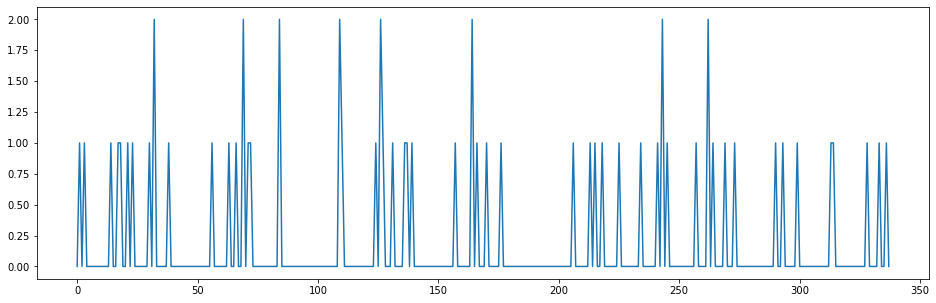

In [48]:
plt.figure(figsize=(16, 5))
df.plot()
plt.show()

In [17]:
std_model = model_1()
compile_model(std_model)
history = std_model.fit(X_train, y_train, epochs=400, batch_size=32)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 47)                2397      
Total params: 12,797
Trainable params: 12,797
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/400
2/2 [==============================] - 5s 11ms/step - loss: 0.0638
Epoch 2/400
2/2 [==============================] - 0s 12ms/step - loss: 0.0615
Epoch 3/400
2/2 [==============================] - 0s 11ms/step - loss: 0.0611
Epoch 4/400
2/2 [==============================] - 0s 11ms/step - loss: 0.0592
Epoch 5/400
2/2 [==============================] - 0s 11ms/st

2/2 [==============================] - 0s 10ms/step - loss: 0.0549
Epoch 95/400
2/2 [==============================] - 0s 10ms/step - loss: 0.0534
Epoch 96/400
2/2 [==============================] - 0s 10ms/step - loss: 0.0540
Epoch 97/400
2/2 [==============================] - 0s 11ms/step - loss: 0.0545
Epoch 98/400
2/2 [==============================] - 0s 9ms/step - loss: 0.0534
Epoch 99/400
2/2 [==============================] - 0s 11ms/step - loss: 0.0546
Epoch 100/400
2/2 [==============================] - 0s 10ms/step - loss: 0.0537
Epoch 101/400
2/2 [==============================] - 0s 10ms/step - loss: 0.0543
Epoch 102/400
2/2 [==============================] - 0s 10ms/step - loss: 0.0548
Epoch 103/400
2/2 [==============================] - 0s 9ms/step - loss: 0.0543
Epoch 104/400
2/2 [==============================] - 0s 10ms/step - loss: 0.0538
Epoch 105/400
2/2 [==============================] - 0s 9ms/step - loss: 0.0545
Epoch 106/400
2/2 [==============================]

2/2 [==============================] - 0s 10ms/step - loss: 0.0528
Epoch 196/400
2/2 [==============================] - 0s 12ms/step - loss: 0.0516
Epoch 197/400
2/2 [==============================] - 0s 11ms/step - loss: 0.0523
Epoch 198/400
2/2 [==============================] - 0s 10ms/step - loss: 0.0525
Epoch 199/400
2/2 [==============================] - 0s 10ms/step - loss: 0.0519
Epoch 200/400
2/2 [==============================] - 0s 9ms/step - loss: 0.0523
Epoch 201/400
2/2 [==============================] - 0s 10ms/step - loss: 0.0524
Epoch 202/400
2/2 [==============================] - 0s 9ms/step - loss: 0.0516
Epoch 203/400
2/2 [==============================] - 0s 9ms/step - loss: 0.0516
Epoch 204/400
2/2 [==============================] - 0s 10ms/step - loss: 0.0515
Epoch 205/400
2/2 [==============================] - 0s 12ms/step - loss: 0.0520
Epoch 206/400
2/2 [==============================] - 0s 10ms/step - loss: 0.0521
Epoch 207/400
2/2 [==========================

2/2 [==============================] - 0s 9ms/step - loss: 0.0470
Epoch 297/400
2/2 [==============================] - 0s 10ms/step - loss: 0.0473
Epoch 298/400
2/2 [==============================] - 0s 9ms/step - loss: 0.0469
Epoch 299/400
2/2 [==============================] - 0s 9ms/step - loss: 0.0476
Epoch 300/400
2/2 [==============================] - 0s 9ms/step - loss: 0.0478
Epoch 301/400
2/2 [==============================] - 0s 9ms/step - loss: 0.0470
Epoch 302/400
2/2 [==============================] - 0s 11ms/step - loss: 0.0475
Epoch 303/400
2/2 [==============================] - 0s 10ms/step - loss: 0.0470
Epoch 304/400
2/2 [==============================] - 0s 11ms/step - loss: 0.0470
Epoch 305/400
2/2 [==============================] - 0s 10ms/step - loss: 0.0482
Epoch 306/400
2/2 [==============================] - 0s 10ms/step - loss: 0.0468
Epoch 307/400
2/2 [==============================] - 0s 9ms/step - loss: 0.0473
Epoch 308/400
2/2 [=============================

2/2 [==============================] - 0s 10ms/step - loss: 0.0445
Epoch 398/400
2/2 [==============================] - 0s 9ms/step - loss: 0.0447
Epoch 399/400
2/2 [==============================] - 0s 9ms/step - loss: 0.0439
Epoch 400/400
2/2 [==============================] - 0s 8ms/step - loss: 0.0437


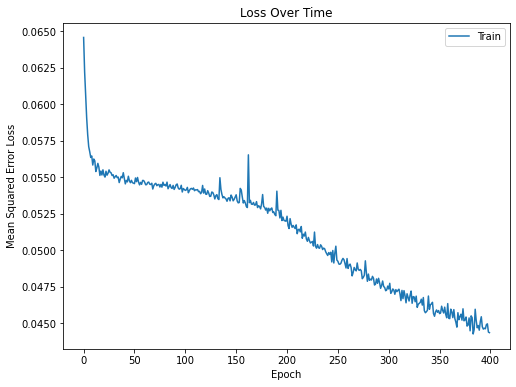

In [47]:
plt.plot(history.history['loss'], label="Train")

plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

In [18]:
predictions = std_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

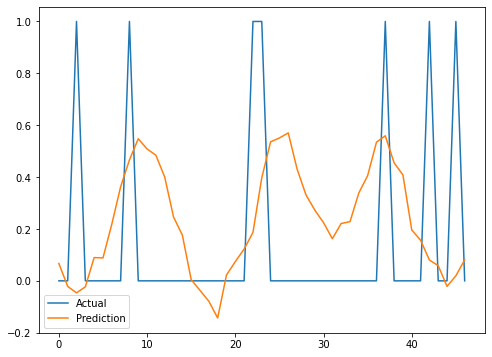

In [49]:
plt.plot(y_test, label="Actual")
plt.plot(predictions.reshape(-1, 1), label="Prediction")
plt.legend()
plt.show()

In [19]:
predictions[predictions>0.2].sum()

9.699376

In [50]:
# Не работает на всем датасете,
rmse = np.sqrt(skm.mean_squared_error(y_test, predictions.reshape(-1, 1)))
print("RMSE:", rmse)

print("Error rate:", calc_error_rate(predictions, y_test))

RMSE: 0.41711150639344335
Error rate: 55.91754913330078


### Сравнение
Проведем тест двух архитектур и сравним результаты. Считать будем сумму очков (гол+пас). Отдельно для игроков атаки и защитников. Предсказывать будем статистику в сезоне 2020-2021

In [20]:
comp = pd.read_csv('rnn_compare.csv')

In [28]:
comp.loc[0:3, 'pos'] = 'forward'
comp.loc[4::, 'pos'] = 'defense'

In [36]:
comp['points_20'] = comp['goals_20'] + comp['pass_20']
comp['points_rnn1'] = comp['pr1_goals'] + comp['pr1_pass']
comp['points_rnn2'] = comp['pr2_goals'] + comp['pr2_pass']

In [38]:
comp

,player,goals_20,pass_20,pr1_goals,pr1_pass,pr2_goals,pr2_pass,pos,points_20,points_rnn1,points_rnn2
0,Nazem Kadri,11,21,14,18,23,23,forward,32,32,46
1,James van Riemsdyk,17,26,21,24,22,20,forward,43,45,42
2,Derick Brassard,8,12,15,28,13,14,forward,20,43,27
3,Artturi Lehkonen,7,6,10,12,7,14,forward,13,22,21
4,P.K. Subban,5,14,7,15,8,20,defense,19,22,28
5,John Klingberg,7,29,9,26,10,36,defense,36,35,46
6,Jared Spurgeon,7,18,6,20,12,14,defense,25,26,26
7,Shayne Gostisbehere,9,11,6,26,7,28,defense,20,32,35


#### Нападающие

In [43]:
# сеть 1
mean_squared_error(comp.loc[comp.pos=='forward', 'points_20'], comp.loc[comp.pos=='forward', 'points_rnn1'])

153.5

In [44]:
# сеть 2
mean_squared_error(comp.loc[comp.pos=='forward', 'points_20'], comp.loc[comp.pos=='forward', 'points_rnn2'])

77.5

#### Защитники

In [41]:
# сеть 1
mean_squared_error(comp.loc[comp.pos=='defense', 'points_20'], comp.loc[comp.pos=='defense', 'points_rnn1'])

38.75

In [45]:
# сеть 2
mean_squared_error(comp.loc[comp.pos=='defense', 'points_20'], comp.loc[comp.pos=='defense', 'points_rnn2'])

101.75

Из сравнения видно, что сеть с одним слоем LSTM лучше подходит для прогнозирования статистики защитников, а сеть с двумя слоями (bidirectional) лучше предсказывает статистику нападающих. 

Это связано с особенностью набор очков. Защитники могут несколько матчей на набирать очки, после нескольких результативных матчей, сеть с двумя слоями можкт слишком сильно "задрать статистику". Для нападпющих наоборот, матчи с несколькими набранными очками могут пройти "незамеченными" для сети с одним слоем.   
Также влияет 

## Вывод  
Лучше использовать 2 сети для разных типов игроков  
Для тех игроков, которые провели мало матчей - сокращать окно, и прогноз кратно части сезона. Это в основном молодые игроки и никто не знает как они заиграют. С другой стороны у них маленькие контракты и они не представляют "опасности" для клуба

## БОНУС. ПРОГНОЗИРУЕМ СЛЕДУЮЩИЙ СЕЗОН    
Цель проекта предсказать и выбрать игроков для драфта, но интересно же как проведут звезды свой следующий сезон? 

Никита Кучеров, весь сезон пропустил из-за травмы.   В плей-офф за 16 матчей набрал 27 очков (5+22) Посмотрим прогноз нейросети.  10 голов + 21 передач = 31 очков. В сумме погрешность 10% , это плейофф и уровень соперников повыше  
<BR>  
    
Райн Нюджент-Хопкинс, один из лучших свободных агентов, будущим летом. 12+23 передачи по прогнозу. По факту вышло за 52 игры 16+19. Тоже суммарно 35 !!!   

#### Овечкин
    
Сколько должен был забить Овечкин, если бы Вашингтон не страдал ~~херней~~ проблемами в атаке ? Правильный ответ 25 голов вместо 24х, похоже у Сашки чуть раньше начался спад, чем думают другие.   
 
А сколько он сможет забить в следующем сезоне, если будет полноценный сезон (82 матча)? Нейросеть говорит, что 55 еще может ))   
<BR>
А сколько за 3 сезона (240 матчей)? До Грецки еще 164 шайбы. Очень приблизительный ответ 139 шайб (55 в 2021-22, примерно по 42 в сезонах 22-23 и 23-24) и останется еще 25 шайб до Грецки. Ждем контракт Овечкина на 4 года, за 3 не управиться. 
<BR>
    
**Теперь пройдемся по защитникам.**
<BR>
Мэтт Дамба 6+15 за 51 игру. Прогноз от нейросети 9+15
<BR>

Квин Хьюз. Защитник-новичок, провел только 126 матчей. Проверим его результативность в последние 20 матчей сезона.   Прогноз 7 голов +  26 передач.  По факту 1 + 12. Слишком маленькое окно, для новичков не очень подходит. 
<BR>

Райн Мюррей. Свободный агент. В прошлом сезоне 0+14. По прогнозу  1+9. Первый сезон остался без заброшенных шайб. Ну чтож, бывает
<BR>

А если посложней? Количество силовых приемов от Суббана ? В прошлом сезоне было 41. По прогнозу 59 ))) В прошлом сезоне было 88 при 68 играх, еще год назад (2018) 56 при 68 играх. Увеличение окна немного улучшает результат (52) 
<BR>

И напоследок. Так-ли хорош лучший защитник-снайпер сокращенного сезона Якоб Чичрун, 18+23 в 56 играх. Посмотрим сколько сможет набрать в следующем сезоне. 
Ответ: 27 шайб и 21 передача. Голов больше чем передач, такое вообще возможно у защитников? Оливер Экман-Ларссон также из Аризоны набрал 23+20 в 2014 году. 